In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_log_error, r2_score, make_scorer
from sklearn.model_selection import learning_curve
from scipy.stats import norm

In [2]:
train = pd.read_csv('training.csv', parse_dates=['transaction_date'])
card_group = pd.read_csv('mcc_group_definition.csv')
transaction = pd.read_csv('transaction_types.csv')


In [3]:
train = train.drop(['dataset_transaction','dataset_user'], axis=1)


In [4]:
# merge data
train2 = train.merge(card_group, on='mcc_group', how='left').drop('mcc_group', axis=1)

train2 = (train2
          .merge(transaction, left_on='transaction_type', right_on='type', suffixes=('_card', '_transaction'))
          .drop(['type','transaction_type'], axis=1))


In [5]:
train2.amount_n26_currency.max()

1166

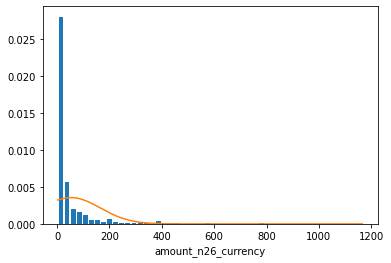

In [6]:

plt.hist(train2.amount_n26_currency, bins=50,rwidth=0.8,density=True)
# plt.show()
rng = np.arange(train2.amount_n26_currency.min(), train2.amount_n26_currency.max(), 0.1)
plt.plot(rng,norm.pdf(rng,train2.amount_n26_currency.mean(),train2.amount_n26_currency.std()))
plt.xlabel('amount_n26_currency')
plt.ylabel('')
plt.show()

In [7]:
# from scipy.stats import skew, kurtosis
# skew(train2['amount_n26_currency'].dropna())
log_amont = np.log(train2.amount_n26_currency)


In [8]:
log_amont.skew()

0.8352641610723656

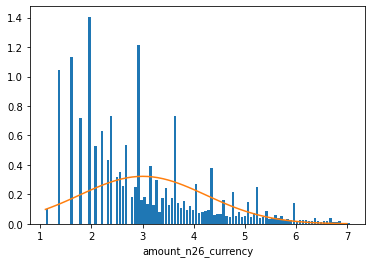

In [9]:

plt.hist(log_amont, bins=100,rwidth=0.8,density=True)
# plt.show()
rng = np.arange(log_amont.min(), log_amont.max(), 0.1)
plt.plot(rng,norm.pdf(rng,log_amont.mean(),log_amont.std()))
plt.xlabel('amount_n26_currency')
plt.ylabel('')
plt.show()

In [ ]:
train2.mean()

In [ ]:
train2.amount_n26_currency.max()

In [ ]:
train2.amount_n26_currency.std()

In [ ]:
upper_limit = train2.amount_n26_currency.mean() + 4*train2.amount_n26_currency.std()
upper_limit
# any salary more than upper limit is an outlier

In [ ]:
# aggregate the last 2 functions

def plot_bar(feature):
    g = sns.catplot(x=feature, 
                    data=train2,
                    order = train2[feature].value_counts().index,
                    kind='count', 
                    height=7, 
                    aspect = 3, 
                    palette="Paired", 
                    edgecolor=".6")
    g.set_xticklabels(rotation=90)

def weekly_popularity_trend(feature):
    """
    Feature popularity on weekly basis
    """
    f = train2.groupby([feature, pd.Grouper(key='transaction_date',freq='W')]).size().reset_index()
    f['transaction_date'] = f['transaction_date'].dt.date
    f.columns = [feature,'transaction_date','count']
    sns.catplot(x="transaction_date", 
            y = 'count',
            hue = feature, 
            data=f, 
            kind='point', 
            height=7, 
            aspect= 1,
            palette='Paired')
    _ = plt.xticks(rotation=90)
    
    
def weekly_currency_trend(feature):
    """
    Mean transaction amount on a weekly basis for a given feature
    """
#     feature = kwargs.get('feature', None)
    f = train2.groupby([*feature, pd.Grouper(key='transaction_date',freq='W')])['amount_n26_currency'].mean().reset_index()
    f_std = train2.groupby([*feature, pd.Grouper(key='transaction_date',freq='W')])['amount_n26_currency'].std().reset_index()
    f['transaction_date'] = f['transaction_date'].dt.date
    
    f_std['transaction_date'] = f_std['transaction_date'].dt.date
    f.columns = [*feature,'transaction_date','mean']
    f_std.columns = [*feature,'transaction_date','std']
    
    f_final = f.merge(f_std)
    hue = feature[0]
    
    # correlating features or maybe not! 
    if feature[1]:
        g = sns.catplot(x="transaction_date", 
                y = 'mean',
                hue = feature[0],
                col = feature[1],
                data=f, 
                kind='point', 
                height = 7,
                aspect = 1.5,
                palette=sns.color_palette("bright", 10)
                )
        g.set_xticklabels(rotation=90)
    else:
        g = sns.catplot(x="transaction_date", 
        y = 'mean',
        hue = feature[0],
        col = feature[1],
        data=f, 
        kind='point', 
        height = 7,
        aspect = 1.5,
        palette=sns.color_palette("bright", 10)
        )
        g.set_xticklabels(rotation=90)
        autocorrelation_plot(f['mean'])
#     x = np.arange(len(f['mean']))
#   plt.errorbar(x,f_final['mean'],yerr=f_final['std'])


In [ ]:
# does not make sense to make a error bar for the direction
weekly_currency_trend(feature = ['explanation_transaction','direction'])



In [ ]:
train2['agent'].unique()

## seperating in and out data for income and expenses predictions respectively

In [ ]:
in_data, out_data= train2[(mask:=train2['direction'] == "In")], train2[~mask]
in_data = in_data.drop(['direction','explanation_card','explanation_transaction','agent'], axis=1)
out_data = out_data.drop(['direction','explanation_card','explanation_transaction','agent'], axis=1)

In [ ]:
class feature_engineering_datetime(TransformerMixin, BaseEstimator):
    

    def fit(self, X, y=None):
        return self

    def transform(self, X, y = None):
        col = 'transaction_date'
        X[f"{'transaction_date'}_weekday"] = X['transaction_date'].dt.dayofweek
        X[f"{'transaction_date'}_week"] = X['transaction_date'].dt.isocalendar().week
        X[f"{'transaction_date'}_day_week"] = X['transaction_date'].dt.day
#         X[f"{'transaction_date'}_week_year"] = X['transaction_date'].dt.year
        self.names = X[[x for x in X.columns if 'prev_' in x]].columns.tolist()
        return X[(elem for elem in X.columns if '_week' in elem)].values
    def feature_names(self):
        return self.names

In [ ]:
class feature_engineering(TransformerMixin, BaseEstimator):
    

    def fit(self, X, y=None):
        return self

    def transform(self, X, y = None):
        #lags= [1,5,7,14]
        lags= [5,7]
        for lag in lags:
            print('in timestamp of lags')
        # lag feature
        #A moving average is commonly used with time series data to smooth out short-term fluctuations and highlight longer-term trends or cycles.
            X[f'prev_lag_mean_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).fillna(0)
#             # rolling average
            X[f'prev_lag_rolling_mean_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).rolling(2).mean().fillna(0)
#             # cumulative average
            X[f'prev_lag_expand_mean_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).expanding().mean().fillna(0)
#             # exponential moving average
            X[f'prev_lag_ewm_mean_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).ewm(0.1).mean().fillna(0)
    
            X[f'prev_lag_rolling_std_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).rolling(2).std().apply(np.std).fillna(0)
        
            X[f'prev_lag_expand_std_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).expanding().std().apply(np.std).fillna(0)
            
            X[f'prev_lag_ewm_std_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).ewm(0.1).std().apply(np.std).fillna(0)
            
        self.names = X[[x for x in X.columns if 'prev_' in x]].columns.tolist()

        return X[[x for x in X.columns if 'prev_' in x]].values


    def feature_names(self):
        return self.names
    

In [ ]:
def generate_pipeline(**kwargs):
    
    features = ColumnTransformer(
        [('date_time_features',feature_engineering_datetime(), ['transaction_date']),
         ('lag_features',feature_engineering(), ['user_id','amount_n26_currency'])
        ],  
        remainder='drop',
        sparse_threshold=0.3,
        n_jobs=None,
        transformer_weights=None
    )

    
    # can use any sklearn estimator
    clf = XGBRegressor(n_estimators=100, random_state=42, booster='gbtree')
        
  
    model = Pipeline([
        ('features', features),
        # ('clf', clf)
    ]) 
    return model

In [ ]:
in_data = in_data.sort_values(['user_id','transaction_date']).reset_index(drop=True)
# split data set 
train = in_data[in_data['transaction_date'].dt.month < 7].reset_index(drop=True) # from feb to june
test = in_data[in_data['transaction_date'].dt.month == 7].reset_index(drop=True) # test july
y_train = np.log1p(train['amount_n26_currency'])
y_test = np.log1p(test['amount_n26_currency'])

In [ ]:
model = generate_pipeline()



In [ ]:
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
a = plot_acf(np.log(train2.amount_n26_currency))
a

In [20]:
model.fit(train)

in timestamp of lags


KeyboardInterrupt: 

In [ ]:
# initialise the model and fit
xgb = XGBRegressor(booster='gbtree', random_state=42)
# xgb.fit(model.transform(train), y_train)

In [ ]:
# xgb boost needs a ndarray as a training input
xgb.fit(model.transform(train),y_train,verbose=True)


In [ ]:
# plot feature importance
# search.best_estimator_.named_steps
from pandas.plotting import autocorrelation_plot


feature_names = (model.named_steps['features'].named_transformers_['date_time_features'].feature_names() + 
                model.named_steps['features'].named_transformers_['lag_features'].feature_names())

feature_imp = pd.DataFrame(sorted(zip(xgb.feature_importances_ ,feature_names)), columns=['Value','Feature'])

# plt.figure(figsize=(20, 30))
# sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(50))
# plt.errorbar(feature_imp['Value'],feature_imp['Feature'])

# plt.title('XGB Features')
# plt.show()

In [ ]:
feature_imp

In [ ]:
# plot_acf(feature_imp['Value'])
# # mean of the lags grouped by user id
# # this will


In [ ]:
f_n = []
f_v = []
for i,j in enumerate(feature_imp['Feature']):
    if '_mean_' in feature_imp['Feature'][i]:
        f_n.append(feature_imp.iloc[i]['Feature'])
        f_v.append(feature_imp.iloc[i]['Value'])


In [ ]:
plt.figure(figsize=(25,15))
plt.bar(f_n,f_v)

In [ ]:
xgb.fit(model.transform(train), y_train)

In [ ]:
y_pred = xgb.predict(model.transform(test))


In [ ]:
# !pip install pmdarima
# from pmdarima import auto_arima
# df = pd.DataFrame()
# df1 = pd.DataFrame()
df3 = pd.DataFrame()

In [ ]:
# df3 = train.groupby(['transaction_date'])['amount_n26_currency'].mean().reset_index()

In [ ]:
df3 = train.groupby(['user_id'])['amount_n26_currency'].mean().reset_index()

In [ ]:
df3

In [ ]:
df4 = test.groupby(['user_id'])['amount_n26_currency'].mean().reset_index()

In [ ]:
# df3['grouped_userid_amount'] = train.groupby(['user_id'])['amount_n26_currency']
# # df1['userid','grouped_userid_amount'] = train.groupby(['user_id'])['amount_n26_currency']

# # f_std = train2.groupby([*feature, pd.Grouper(key='transaction_date',freq='W')])['amount_n26_currency'].std().reset_index()
#df3['grouped_userid_amount'].iloc[1][1]

In [ ]:
auto_arima(df3['amount_n26_currency'],trace=True)

In [ ]:
auto_arima(df4['amount_n26_currency'],trace=True)

In [ ]:
y_train_trial = np.log1p(df3['amount_n26_currency'])

In [ ]:
xgb.fit(df3['amount_n26_currency'],y_train_trial)

In [ ]:
xgb.predict(df4['amount_n26_currency'])

In [ ]:
y_train1 = np.array(y_train)

In [ ]:
y_train1

In [ ]:
train


In [ ]:
aa = RandomForestRegressor()

In [ ]:
aa.fit(model.transform(train),y_train1)

In [ ]:
te

In [ ]:
y = aa.predict(model.transform(test))

In [ ]:
y

In [ ]:
y_test 

In [ ]:
bb = SGDRegressor()

In [ ]:
aaa = bb.fit(model.transform(train),y_train1)

In [ ]:
yb = bb.predict(model.transform(test))

In [ ]:
yb

In [ ]:
y_test

In [ ]:
plt.plot(y,color='green')


In [ ]:
plt.plot(y_test)

In [ ]:
from fbprophet import Prophet


In [ ]:
train

In [ ]:
transformed_data = model.transform(train)

In [ ]:
transformed_data = pd.DataFrame(transformed_data)


In [ ]:
transformed_data

In [ ]:
my_model = Prophet(interval_width=0.95)

In [ ]:
subdf = train[['transaction_date','amount_n26_currency']]

In [ ]:
train

In [ ]:
y_train

In [ ]:
subdf_test = test[['transaction_date','amount_n26_currency']]

In [ ]:
subdf

In [ ]:
subdf = subdf.rename(columns={'transaction_date':'ds', 'amount_n26_currency':'y'})
subdf['y'] = original_log_train_data

In [ ]:
subdf

In [ ]:
# subdf_test = subdf_test.rename(columns={'transaction_date':'ds', 'amount_n26_currency':'y'})
# subdf_test['y'] = original_log_train_data

In [ ]:
m = Prophet()
m.fit(subdf)

In [ ]:
# original_log_train_data = np.log1p(subdf['y'])

In [ ]:
# from scipy.stats import norm
# import statistics
# x_axis = np.arange(-10, 10, 0.01)


# mean = statistics.mean(original_log_train_data)
# sd = statistics.stdev(original_log_train_data)
  
# plt.plot(x_axis, norm.pdf(x_axis, mean, sd))
# plt.show()

In [ ]:
future = m.make_future_dataframe(periods=31,freq='D')
future1 = m.predict(future)

In [ ]:
future1

In [ ]:
plot1 = m.plot(future1)

In [ ]:


from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(future1)
a = add_changepoints_to_plot(fig.gca(), m, future1)



In [ ]:
future2 = m.predict(subdf_test)
plot3 = m.plot(future2)

In [ ]:
plot2 = m.plot_components(future1)

In [ ]:
# y_pred = np.log1p(future1['yhat'])
# y_test

In [ ]:


from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)



In [ ]:
plt.figure(figsize=(25,15))

plt.bar(forecast['ds'],forecast['weekly'])